In [3]:
import matplotlib.pyplot as plt
from typing import List, Optional
import itertools
import os
import pickle
import numpy as np
from numpy import linalg as LA

from src.oracles.base import ArrayPair

In [4]:
comm_budget_experiment = 5000
labels = ['EGD-GT', 'EGD-CON', 'Sliding', 'Alg.2']#'Alg.1']

In [5]:
def saddle_grad_norm(a: ArrayPair, b: ArrayPair, **kwargs):
    x, y = (a - b).tuple()
    return LA.norm(x.sum(axis=0) / x.shape[0]) ** 2 + LA.norm(y.sum(axis=0) / y.shape[0]) ** 2

In [8]:
def plot_algorithms(
    graph: str,
    num_nodes: int,
    data_name: str,
    labels: List[str],
    methods: List[str],
    stepsize_factors: List[float],
    dist_types: Optional[List[str]] = ["argument", "gradient", "consensus"],
    logs_path: Optional[str] = "./logs",
    plots_path: Optional[str] = "./plots",
    experiment_type: Optional[str] = "real",
    save_to: Optional[str] = None,
):
    for type_ in dist_types:
        plt.figure(figsize=(12, 6))
        plt.title(f"{graph} graph, {num_nodes} nodes, {data_name}", fontsize=25)
        marker = itertools.cycle(("o", "v", "^", "<", ">", "s", "8", "p"))

        ax = plt.gca()
        min_comm = np.inf
        flag = True
        if type_ == "argument":
            plt.ylabel("$||\overline{z} - z^*||^2$", fontsize=22)
        elif type_ == "gradient":
            plt.ylabel("$||\dfrac{1}{M} \sum_{m=1}^{M} F_m(z_m)||^2$", fontsize=22)
        elif type_ == "consensus":
            plt.ylabel("dist. to consensus", fontsize=22)
            flag = False
        else:
            raise ValueError(f"Unknown distance to optimum type: {type_}!")
        for method, label in zip(methods, labels):
            path = os.path.join(
                logs_path, experiment_type, graph, f"{num_nodes}_{data_name}"
            )
            os.system(f"mkdir -p {os.path.join(path, type_)}")

            def find_best_param(method: str) -> np.ndarray:
                dist_best = np.array([])
                min_dist = np.inf
                for method_name in [
                    method + f"_{stepsize_factor}"
                    for stepsize_factor in stepsize_factors
                ] + [method]:
                    with open(
                        os.path.join(path, type_, f"{method_name}.pkl"), "rb"
                    ) as f:
                        dist = pickle.load(f)
                        if np.min(dist) < min_dist:
                            min_dist = np.min(dist)
                            dist_best = dist
                    return dist_best

            dist = find_best_param(method)

            with open(os.path.join(path, "z_true"), "rb") as f:
                z_true = pickle.load(f)
                z_0 = ArrayPair.zeros(z_true.x.shape[0])
            #comm_steps = np.arange(len(dist)) * (comm_budget_experiment / len(dist))
            color = next(ax._get_lines.prop_cycler)["color"]
#             if flag:
#                 i = np.where(dist == np.amin(dist))[0][0]
#                 if dist[i] < min_comm:
#                     min_comm = comm_steps[i]

#                 if type_ == "argument":
#                     dist /= (z_0 - z_true).dot(z_0 - z_true)
#                 elif type_ == "gradient":
#                     dist /= saddle_grad_norm(z_0, z_true)
            plt.plot(
                #comm_steps,
                dist,
                label=label,
                marker=next(marker),
                color=color,
                markevery=0.15,
                markersize=6,
            )

        plt.xlabel("communications", fontsize=22)
#         if flag:
#             plt.xlim((0, min_comm))
        plt.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
        plt.tick_params(labelsize=15)
        plt.yscale("log")
        plt.legend(fontsize=16, loc="lower left")
        plt.grid()
        plt.tight_layout(rect=[0, 0, 1, 0.93])

        if save_to is not None:
            path = os.path.join(plots_path, experiment_type, type_, graph)
            os.system(f"mkdir -p {path}")
            plt.savefig(os.path.join(path, f"{num_nodes}_{data_name}{save_to}.pdf"))
            plt.close()
        else:
            plt.show()

In [10]:
for graph in ["grid", "star", "ring"]:
    for dataset in ["a7a", "a9a", "w7a", "w8a", "phishing"]:
        plot_algorithms(
            graph,
            25,
            dataset,
            labels,
            ["extragrad", "extragrad_con", "sliding", "vi_adom"],#"vi_papc"],
            [0.1, 0.01, 0.001], #[3.0, 0.1, 0.01, 0.001],
            save_to="_PS_alg2",#"_PS",
        )

# Parameter search

In [11]:
print(
    [
        method + f"_{stepsize_factor}"
        for method in ["extragrad", "extragrad_con", "sliding", "vi_papc"]
        for stepsize_factor in [3.0, 0.1, 0.01, 0.001]
    ]
)

['extragrad_3.0', 'extragrad_0.1', 'extragrad_0.01', 'extragrad_0.001', 'extragrad_con_3.0', 'extragrad_con_0.1', 'extragrad_con_0.01', 'extragrad_con_0.001', 'sliding_3.0', 'sliding_0.1', 'sliding_0.01', 'sliding_0.001', 'vi_papc_3.0', 'vi_papc_0.1', 'vi_papc_0.01', 'vi_papc_0.001']


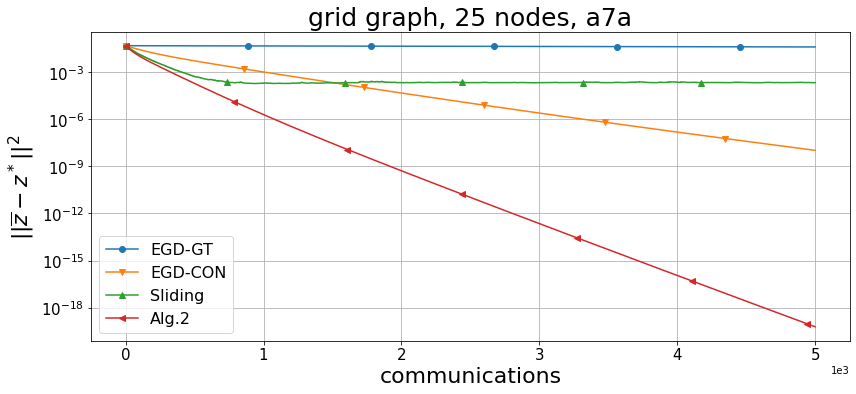

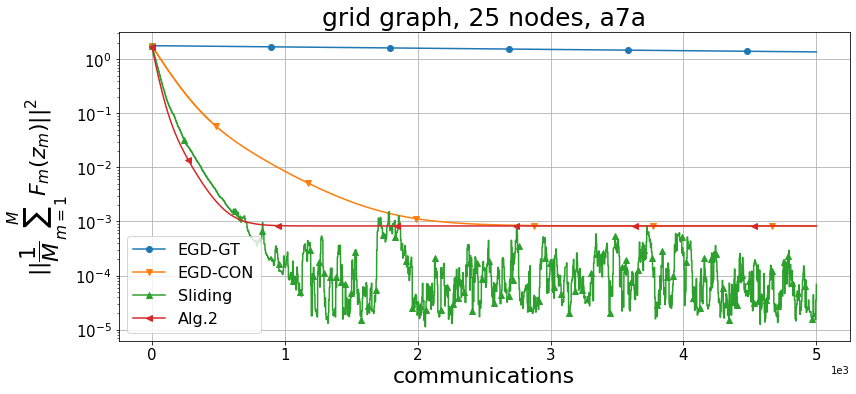

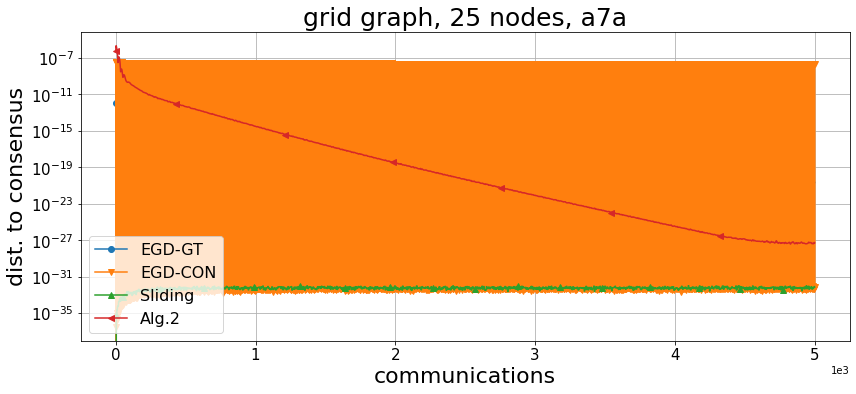

In [17]:
plot_algorithms(
    "grid",
    25,
    "a7a",
    labels,
    ["extragrad", "extragrad_con", "sliding", "vi_adom"], # "vi_papc"]
    [0.25, 0.1, 0.01, 0.001],
    #save_to=True,
)